BLACK SCHOLES MODEL

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as si
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [8]:
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    S: Current stock price
    K: Strike price
    T: Time to expiration (in years)
    r: Risk-free rate (as decimal)
    sigma: Volatility (as decimal)
    option_type: "call" or "put"
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        option_price = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    else:
        option_price = K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0)
    
    return option_price, d1, d2

In [9]:
# Greeks Calculation
def greeks(S, K, T, r, sigma, option_type):
    _, d1, d2 = black_scholes(S, K, T, r, sigma, option_type)
    
    pdf_d1 = si.norm.pdf(d1)
    sqrt_T = np.sqrt(T)
    exp_neg_rt = np.exp(-r * T)

    gamma = pdf_d1 / (S * sigma * sqrt_T)
    vega = S * pdf_d1 * sqrt_T
    if option_type == "call":
        delta = si.norm.cdf(d1)
        theta = (-S * pdf_d1 * sigma / (2 * sqrt_T)) - (r * K * exp_neg_rt * si.norm.cdf(d2))
        rho = K * T * exp_neg_rt * si.norm.cdf(d2)
    else:
        delta = -si.norm.cdf(-d1)
        theta = (-S * pdf_d1 * sigma / (2 * sqrt_T)) + (r * K * exp_neg_rt * si.norm.cdf(-d2))
        rho = -K * T * exp_neg_rt * si.norm.cdf(-d2)

    return {
        'Delta': delta, 'Gamma': gamma, 'Theta': theta / 365, 'Vega': vega * 0.01, 'Rho': rho * 0.01
    }

In [10]:
def fetch_stock_data(ticker):
    """Fetches stock price and implied volatility from Yahoo Finance"""
    stock = yf.Ticker(ticker)
    stock_price = stock.history(period="1d")["Close"].iloc[-1]
    return stock_price

In [11]:
def calculate_time_to_expiry(expiration_date):
    """Calculates the time to expiration in years"""
    today = datetime.date.today()
    expiry = datetime.datetime.strptime(expiration_date, "%Y-%m-%d").date()
    return (expiry - today).days / 365.0

In [12]:
# Visualization Function
def plot_greeks(S, K, T, r, sigma, option_type):
    price_range = np.linspace(S * 0.5, S * 1.5, 50)  # Stock price range for visualization
    greek_values = {'Delta': [], 'Gamma': [], 'Theta': [], 'Vega': [], 'Rho': []}

    for price in price_range:
        greeks_dict = greeks(price, K, T, r, sigma, option_type)
        for key in greek_values:
            greek_values[key].append(greeks_dict[key])

    plt.figure(figsize=(10, 6))
    sns.set_style("darkgrid")
    
    for key in greek_values:
        plt.plot(price_range, greek_values[key], label=key)

    plt.xlabel("Stock Price")
    plt.ylabel("Greek Value")
    plt.title(f"Greeks vs Stock Price ({option_type.capitalize()} Option)")
    plt.legend()
    plt.show()


In [14]:
ticker = input("Enter Stock Ticker (e.g., AAPL, TSLA): ")
S = fetch_stock_data(ticker)
K = float(input("Enter Strike Price: "))
T = calculate_time_to_expiry(input("Enter Expiration Date (YYYY-MM-DD): "))
r = 0.05  # Assume risk-free rate of 5%
sigma = float(input("Enter Implied Volatility (as decimal, e.g., 0.2 for 20%): "))
option_type = input("Enter Option Type (call/put): ")

price, _, _ = black_scholes(S, K, T, r, sigma, option_type)
greeks_values = greeks(S, K, T, r, sigma, option_type)

print(f"The {option_type} option price is: ${price:.2f}")
print("\nGreeks:")
for key, value in greeks_values.items():
    print(f"{key}: {value:.6f}")

The call option price is: $91.10

Greeks:
Delta: 1.000000
Gamma: 0.000000
Theta: -0.021157
Vega: 0.000000
Rho: 0.110018


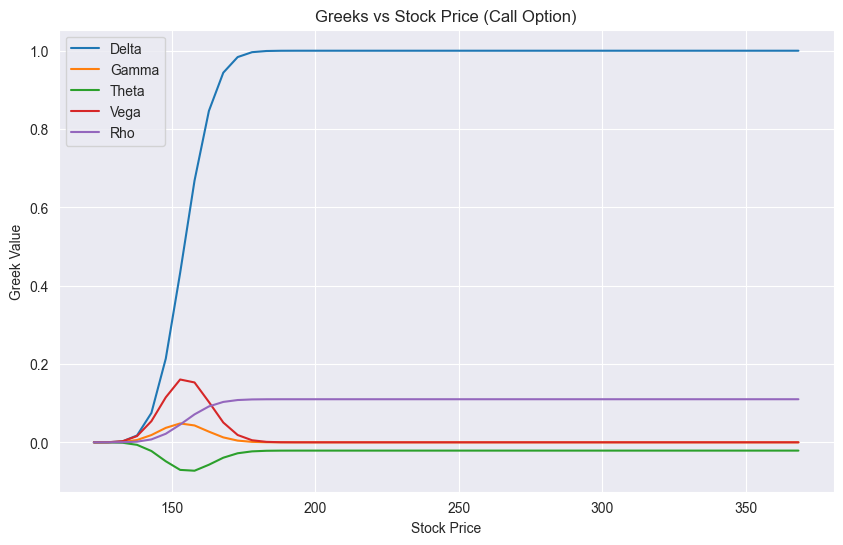

In [15]:
# Plot Greeks
plot_greeks(S, K, T, r, sigma, option_type)

Monte Carlo Simulation for Option Pricing

In [18]:
def monte_carlo_option_pricing(S, K, T, r, sigma, option_type, num_simulations=10000, num_steps=252):
    dt = T / num_steps  # Time step
    np.random.seed(42)  # Set seed for reproducibility

     # Simulate price paths
    stock_prices = np.zeros((num_simulations, num_steps))
    stock_prices[:, 0] = S

    for t in range(1, num_steps):
        Z = np.random.standard_normal(num_simulations)  # Generate random values
        stock_prices[:, t] = stock_prices[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    # Compute option payoffs at expiry
    if option_type == "call":
        payoffs = np.maximum(stock_prices[:, -1] - K, 0)
    else:
        payoffs = np.maximum(K - stock_prices[:, -1], 0)

    # Discount payoffs to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price, stock_prices

In [19]:
# Visualization Function
def plot_monte_carlo(stock_prices, S, K):
    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices.T, color="blue", alpha=0.1)  # Plot all simulations
    plt.axhline(y=S, color="green", linestyle="dashed", label="Initial Price")
    plt.axhline(y=K, color="red", linestyle="dashed", label="Strike Price")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.title("Monte Carlo Simulated Stock Price Paths")
    plt.legend()
    plt.show()

In [21]:
# Main Execution
ticker = input("Enter Stock Ticker (e.g., AAPL, TSLA): ")
S = fetch_stock_data(ticker)
K = float(input("Enter Strike Price: "))
T = calculate_time_to_expiry(input("Enter Expiration Date (YYYY-MM-DD): "))
r = 0.05  # Assume risk-free rate of 5%
sigma = float(input("Enter Implied Volatility (as decimal, e.g., 0.2 for 20%): "))
option_type = input("Enter Option Type (call/put): ").lower()

# Black-Scholes Pricing
bs_price,_, _ = black_scholes(S, K, T, r, sigma, option_type)

# Monte Carlo Pricing
mc_price, stock_paths = monte_carlo_option_pricing(S, K, T, r, sigma, option_type)

# Print Results
print(f"\nBlack-Scholes {option_type} option price: ${bs_price:.2f}")
print(f"Monte Carlo {option_type} option price: ${mc_price:.2f}")


Black-Scholes call option price: $91.10
Monte Carlo call option price: $91.00


c:\Users\91977\OneDrive\Desktop\Quant_Projects\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


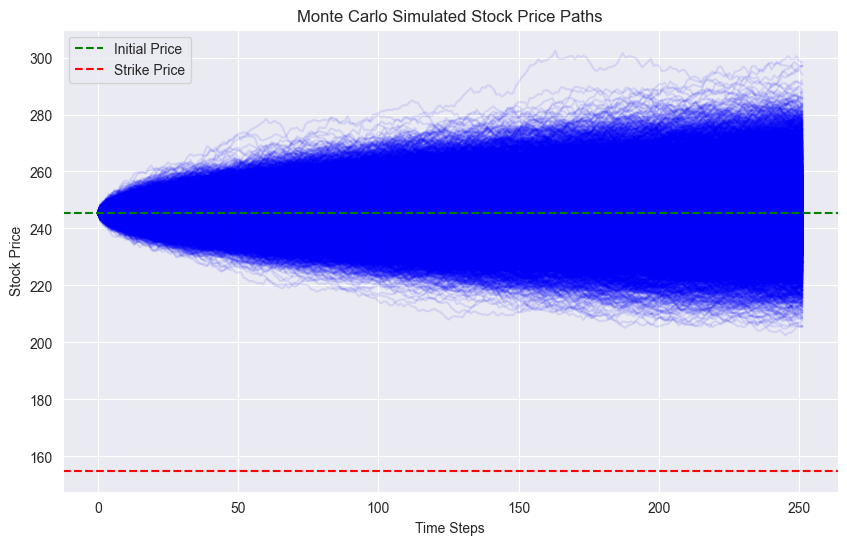

In [22]:
# Plot Monte Carlo Simulations
plot_monte_carlo(stock_paths, S, K)

Bionomial Tree Model

In [23]:
# Binomial Tree Model
def binomial_tree_option_pricing(S, K, T, r, sigma, option_type, N=100):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize stock price tree
    stock_price = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(i+1):
            stock_price[j, i] = S * (u ** (i - j)) * (d ** j)

    # Initialize option values at maturity
    option_value = np.zeros((N+1, N+1))
    if option_type == "call":
        option_value[:, N] = np.maximum(stock_price[:, N] - K, 0)
    else:
        option_value[:, N] = np.maximum(K - stock_price[:, N], 0)

    # Backward induction
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            option_value[j, i] = np.exp(-r * dt) * (p * option_value[j, i+1] + (1 - p) * option_value[j+1, i+1])

    return option_value[0, 0]

In [25]:
ticker = input("Enter Stock Ticker (e.g., AAPL, TSLA): ")
S = fetch_stock_data(ticker)
K = float(input("Enter Strike Price: "))
T = calculate_time_to_expiry(input("Enter Expiration Date (YYYY-MM-DD): "))
r = 0.05  # Assume risk-free rate of 5%
sigma = float(input("Enter Implied Volatility (as decimal, e.g., 0.2 for 20%): "))
option_type = input("Enter Option Type (call/put): ").lower()

# Binomial Tree Pricing
bt_price = binomial_tree_option_pricing(S, K, T, r, sigma, option_type)

# Print Results
print(f"\nBlack-Scholes {option_type} option price: ${bs_price:.2f}")
print(f"Monte Carlo {option_type} option price: ${mc_price:.2f}")
print(f"Binomial Tree {option_type} option price: ${bt_price:.2f}")


Black-Scholes call option price: $91.10
Monte Carlo call option price: $91.00
Binomial Tree call option price: $91.10


In [32]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm



Binomial Tree call option price: $92.59


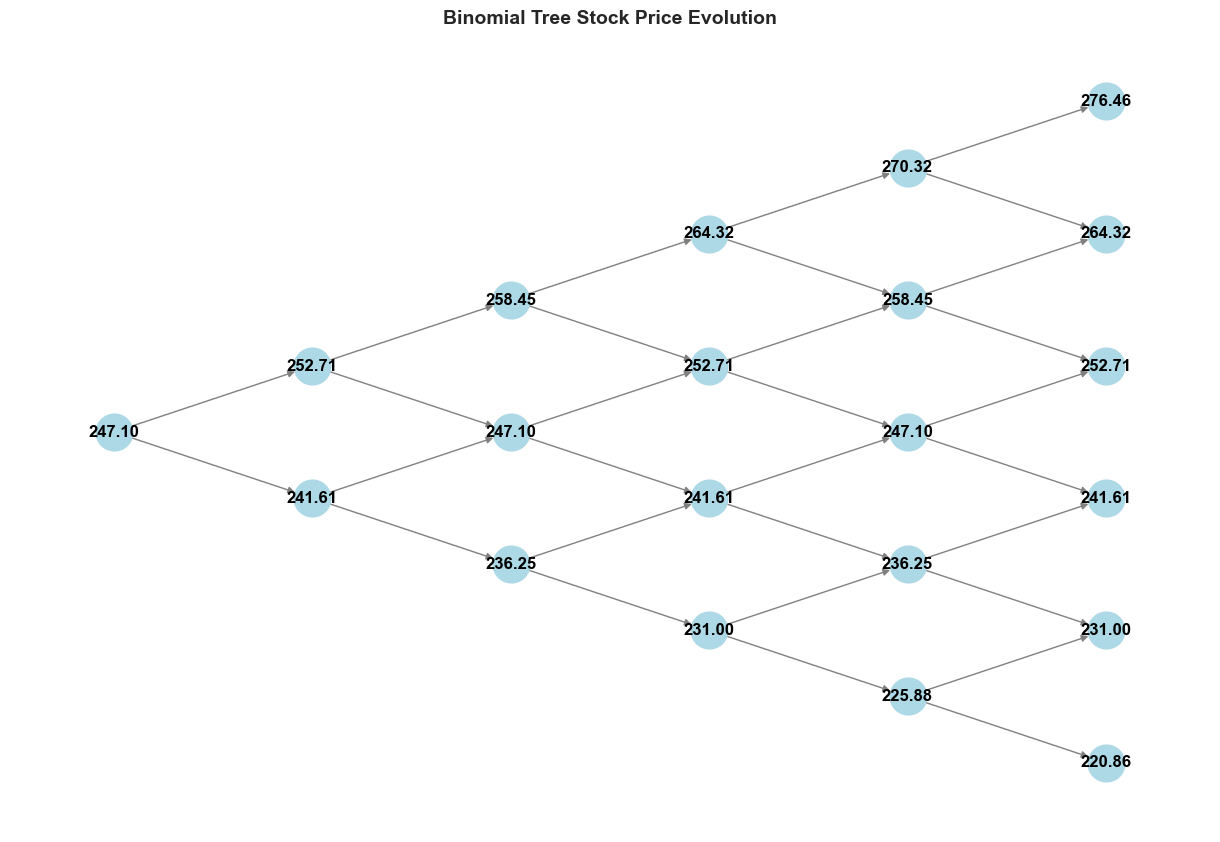

In [49]:
# Binomial Tree Model (Returns both option price and stock price tree)
def binomial_tree_option_pricing(S, K, T, r, sigma, option_type, N=5):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initialize stock price tree
    stock_price = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(i+1):
            stock_price[j, i] = S * (u ** (i - j)) * (d ** j)

    # Initialize option values at maturity
    option_value = np.zeros((N+1, N+1))
    if option_type == "call":
        option_value[:, N] = np.maximum(stock_price[:, N] - K, 0)
    else:
        option_value[:, N] = np.maximum(K - stock_price[:, N], 0)

    # Backward induction for option price
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            option_value[j, i] = np.exp(-r * dt) * (p * option_value[j, i+1] + (1 - p) * option_value[j+1, i+1])

    return option_value[0, 0], stock_price  # Return option price and tree

# Improved Visualization of Binomial Tree
def visualize_binomial_tree(stock_price, N=5):
    G = nx.DiGraph()
    pos = {}  # Position dictionary for nodes

    # Create nodes with better spacing
    for i in range(N+1):  # Time steps
        for j in range(i+1):  # Up/down moves
            G.add_node((i, j))
            pos[(i, j)] = (i, -j + i / 2)  # Adjusted position for readability

    # Create edges
    for i in range(N):  # Time steps
        for j in range(i+1):  # Up/down moves
            G.add_edge((i, j), (i+1, j))    # Down move
            G.add_edge((i, j), (i+1, j+1))  # Up move

    # Draw the graph
    plt.figure(figsize=(12, 8))  # Enlarged figure for better readability
    nx.draw(G, pos, with_labels=False, node_size=700, node_color='lightblue', edge_color='gray', font_size=10)

    # Annotate with stock prices
    for i in range(N+1):
        for j in range(i+1):
            x, y = pos[(i, j)]
            plt.text(x, y, f"{stock_price[j, i]:.2f}", fontsize=12, ha='center', va='center', color='black', fontweight='bold')

    plt.title("Binomial Tree Stock Price Evolution", fontsize=14, fontweight='bold')
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Stock Price Movement", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability
    plt.show()

# Fetch stock price from Yahoo Finance
def fetch_stock_data(ticker):
    stock = yf.Ticker(ticker)
    stock_price = stock.history(period="1d")["Close"].iloc[-1]
    return stock_price

# Calculate time to expiration
def calculate_time_to_expiry(expiration_date):
    today = datetime.date.today()
    expiry = datetime.datetime.strptime(expiration_date, "%Y-%m-%d").date()
    return (expiry - today).days / 365.0

# Main Execution
ticker = input("Enter Stock Ticker (e.g., AAPL, TSLA): ")
S = fetch_stock_data(ticker)
K = float(input("Enter Strike Price: "))
T = calculate_time_to_expiry(input("Enter Expiration Date (YYYY-MM-DD): "))
r = 0.05  # Assume risk-free rate of 5%
sigma = float(input("Enter Implied Volatility (as decimal, e.g., 0.2 for 20%): "))
option_type = input("Enter Option Type (call/put): ").lower()

# Binomial Tree Pricing
bt_price, stock_price_tree = binomial_tree_option_pricing(S, K, T, r, sigma, option_type, N=5)

# Print Results
print(f"\nBinomial Tree {option_type} option price: ${bt_price:.2f}")

# Call the visualization function
visualize_binomial_tree(stock_price_tree, N=5)